In [1]:
import pandas as pd
import re
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Netflix Catalog (2019)

In [2]:
#read data
df_netflix_2019 = pd.read_csv('netflix_titles.csv')

### Data Overview

In [3]:
df_netflix_2019.isnull().sum().sort_values(ascending=False)

director        1969
cast             570
country          476
date_added        11
rating            10
show_id            0
type               0
title              0
release_year       0
duration           0
listed_in          0
description        0
dtype: int64

In [4]:
#overview
df_netflix_2019.dtypes

show_id          int64
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [5]:
df_netflix_2019.shape

(6234, 12)

### Identifying Missing Data

In [6]:
# number of rows missing in each column
# df_netflix_2019.isnull().sum()
# % of rows missing in each column
for column in df_netflix_2019.columns:
    percentage = df_netflix_2019[column].isnull().mean()
    print(f'{column}: {round(percentage*100, 2)}%')

show_id: 0.0%
type: 0.0%
title: 0.0%
director: 31.58%
cast: 9.14%
country: 7.64%
date_added: 0.18%
release_year: 0.0%
rating: 0.16%
duration: 0.0%
listed_in: 0.0%
description: 0.0%


### Dealing with missing data

In [7]:
#1. drop
#drop column
df_netflix_2019.drop('director', axis=1)
#drop row
no_director = df_netflix_2019[df_netflix_2019['director'].isnull()].index
df_netflix_2019.drop(no_director, axis=0)
#~ + .isnull()
df_netflix_2019[~df_netflix_2019['director'].isnull()]
#dropna()
df_netflix_2019.dropna(subset=['director'])

#2. use median, mean (numeric data) or mode (categorical data)
df_netflix_2019[df_netflix_2019['rating'].isnull()]
mode = ''.join(df_netflix_2019['rating'].mode())
df_netflix_2019['rating'].fillna(mode, inplace=True)
#3. replace with arbitrary number or text
df_netflix_2019['duration'].fillna(0, inplace=True)

# backward, forward ->df.fillna(method='bfill') , df.fillna(method='ffill')

### Finding Outliers

#### Numeric Data

In [8]:
#creating column (extract)
df_movie = df_netflix_2019[df_netflix_2019['type']=='Movie']
df_movie = df_movie.assign(minute = df_movie['duration'].str.extract(r'(\d+)', expand=False).astype(int))

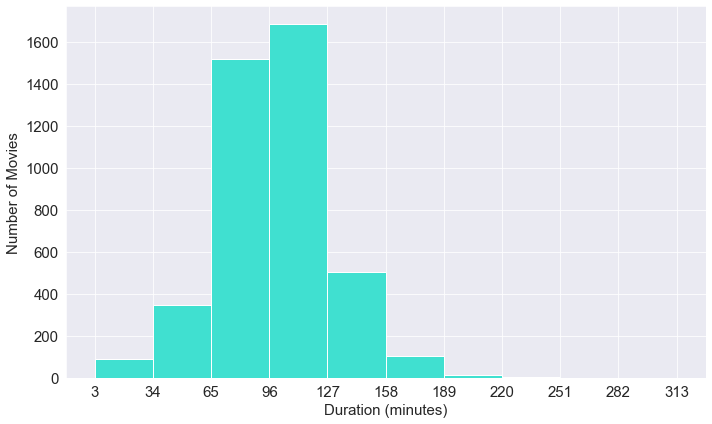

In [9]:
# Histogram
# stylish: lining up  ticks  with the histogram bars
min_minute, max_minute = df_movie['minute'].min(), df_movie['minute'].max()
minbin, maxbin = math.floor(min_minute), math.ceil(max_minute)
gap = maxbin - minbin
#choose number of beens
bins = 10
width = math.ceil(gap/bins)

bins = np.arange(minbin,maxbin+width, width)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(df_movie['minute'], bins=bins, color='turquoise')

fig.set_size_inches(10, 6)
ax.set_xlabel('Duration (minutes)', fontsize=15)
ax.set_ylabel('Number of Movies', fontsize=15)
plt.xticks(bins, fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()
plt.show()
# fig.savefig('histogram_cleaning.png')

#simple
# fig, ax = plt.subplots(nrows=1, ncols=1)
# plt.hist(x=df_movie['minute'])
# fig.tight_layout()

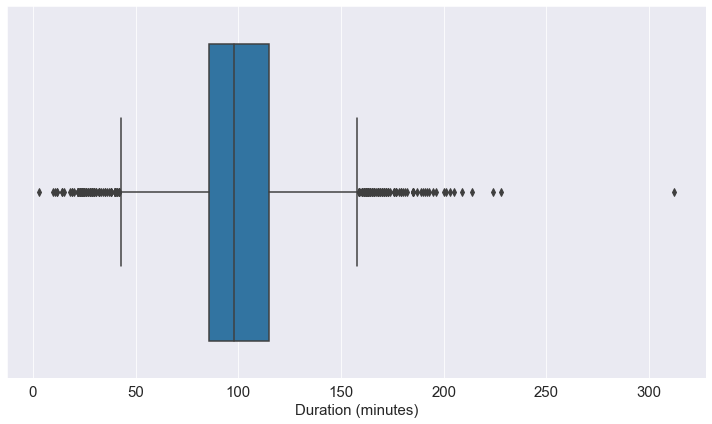

In [10]:
#boxplot
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 6)
ax = sns.boxplot(x=df_movie['minute'])
ax.set_xlabel('Duration (minutes)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()
fig.savefig('boxplot_cleaning.png')

# fig, ax = plt.subplots(nrows=1, ncols=1)
# ax = sns.boxplot(x=df_movie['minute'])
# fig.tight_layout()

In [11]:
#first boxplot
# import plotly.graph_objects as go
# from plotly.offline import iplot, init_notebook_mode

# fig = go.Figure()
# fig.add_box(x=df_movie['minute'], text=df_movie['minute'])
# iplot(fig)

In [12]:
#overview descriptive statitics
df_movie['minute'].describe()

count    4265.000000
mean       99.100821
std        28.074857
min         3.000000
25%        86.000000
50%        98.000000
75%       115.000000
max       312.000000
Name: minute, dtype: float64

#### Categorical data

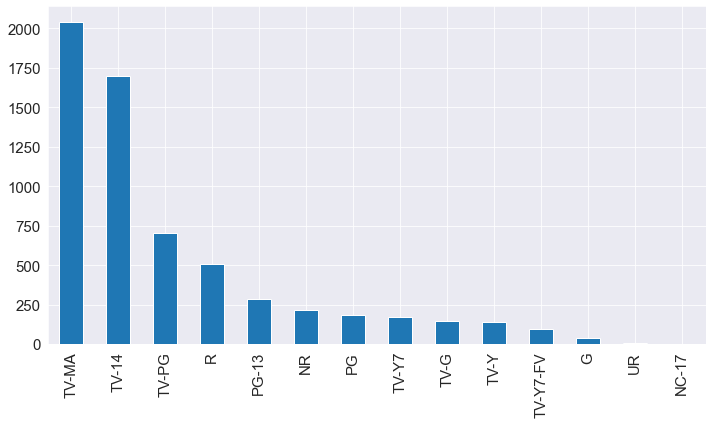

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 6)
fig = df_netflix_2019['rating'].value_counts().plot.bar().get_figure()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()
fig.savefig('bar_cleaning')

### Dealing with Outliers

In [14]:
#outliers
df_movie[(df_movie['minute']<43) | (df_movie['minute']>158)]
#filtering outliers out
df_movie = df_movie[(df_movie['minute']>43) & (df_movie['minute']<158)]

### Inconsistent Data 1

In [16]:
#inconsistent capitalization
df_netflix_2019['title'] = df_netflix_2019['title'].apply(lambda x:x.lower())
# Remove strings in columns (sub, replace) remove punctuation
df_netflix_2019['title'] = df_netflix_2019['title'].apply(lambda x:re.sub('[^\w\s]','',x))
#unnecessary data
df_netflix_2019 = df_netflix_2019.drop_duplicates()
#droping tiltes from the same type (movie or tv) to avoid further problems (34 out)
df_netflix_2019.drop_duplicates(['title','type'], keep='last', inplace=True)

### Netflix Originals (until 2020)

### Inconsitent Data 2

In [17]:
df_netflix_originals = pd.read_csv('netflix_originals.csv')
#inconsintent column names
df_netflix_originals.rename(columns={'titles':'title', 'years':'release_year'}, inplace=True)
# inconsistent dtypes (data must be same type before merging)
df_netflix_originals = df_netflix_originals.astype({"release_year": int})

In [22]:
# example: Dealing with inconsistent names e.g. "New York" vs "NY"
from fuzzywuzzy import process, fuzz
states = ['New York', 'California', 'Washington', 'Hawaii']
df_states = pd.DataFrame({'states':['NY', 'CA', 'Washington DC', 'Hawai']})
df_states[['match', 'score']] = df_states['states'].apply(lambda x:process.extractOne(x, states, scorer=fuzz.token_sort_ratio)).apply(pd.Series)
df_states.value_counts()

states         match       score
CA             California  33       1
Hawai          Hawaii      91       1
NY             New York    40       1
Washington DC  Washington  87       1
dtype: int64

### Text Normalization

In [19]:
#inconsistent capitalization
df_netflix_originals['title'] = df_netflix_originals['title'].apply(lambda x:x.lower())
df_netflix_originals['title'] = df_netflix_originals['title'].str.lower()
#clean leading and trailing spaces
df_netflix_originals['title'] = df_netflix_originals['title'].apply(lambda x:x.strip())
df_netflix_originals['title'] = df_netflix_originals['title'].str.strip()
# remove punctuation: clean characters other than word or spaces
df_netflix_originals['title'] = df_netflix_originals['title'].apply(lambda x:re.sub('[^\w\s]','',x))
df_netflix_originals['title'].replace('[^\w\s]', '', regex=True, inplace=True)

### Final Netflix DataFrame

In [20]:
# we want to identify which movies are netflix originals and which only belong to the catalog so we do an outer join to give 'Catalog' value to all the rows
# that are only in the "df_netflix_2019" dataset
df_netflix = pd.merge(df_netflix_originals, df_netflix_2019, on=['title', 'type', 'release_year'],
                           how='outer')
df_netflix['original'].fillna('Catalog', inplace=True)
#drop_duplicates: data duplicated because of disagreement in releaase_year
df_netflix.drop_duplicates(['title'], keep='first', inplace=True)

In [21]:
df_netflix[['original', 'type']].value_counts()

original  type   
Catalog   Movie      3705
          TV Show    1439
Netflix   TV Show    1009
          Movie       504
dtype: int64